In [1]:
from torch.utils.data import Dataset
import torch
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os


In [17]:
class NiftiDataset(Dataset):
    def __init__(self, source_dir, target_dir, transforms):
        """
        create a dataset in PyTorch for reading NIfTI files
        Args:
            source_dir (str): path to source images
            target_dir (str): path to target images
            transform (callable) transform to apply to both source and target images
        """
        self.source_dir = source_dir
        self.target_dir = target_dir
        self.transform = transforms
        self.source_images = NiftiDataset.get_data_paths(source_dir)
        self.target_images = NiftiDataset.change_path_for_targets(self.source_images)
        
    def get_data_paths(directory):
        paths = []
        for i in os.listdir(directory):
            paths.append(os.path.join(directory, i))
        return paths
    
    def change_path_for_targets(source_images):
        target_images = []
        for i in source_images:
            mapped_string = i.replace("t1", "t2")
            mapped_string = mapped_string.replace("T1_fcm","T2_reg_fcm" )
            target_images.append(mapped_string)
        return target_images
            
    def __len__(self):
        return len(self.source_dir)
    
    def __getitem__(self, idx):
        source_image = nib.load(self.source_images[idx]).get_fdata()
        target_image = nib.load(self.target_images[idx]).get_fdata()
        source_patch, target_patch = self.transform(source_image, target_image)

        return np.transpose(source_patch, (1, 0, 2)), np.transpose(target_patch, (1, 0, 2))
    
class RandomCrop3D:
    def __init__(self, output_size):
        self.output_size = output_size
        
    def generate_patch(self, source, target):
        if isinstance(self.output_size, int):
            crop_start_x = np.random.randint(0, source.shape[0] - self.output_size + 1)
            crop_start_y = np.random.randint(0, source.shape[2] - self.output_size + 1)
            crop_end_x = crop_start_x + self.output_size
            crop_end_y = crop_start_y + self.output_size

            return (source[crop_start_x:crop_end_x, :, crop_start_y: crop_end_y],
                   target[crop_start_x:crop_end_x, :, crop_start_y: crop_end_y])
        
        if isinstance(self.output_size, tuple):
            crop_start_x = np.random.randint(0, source.shape[0] - self.output_size[0] + 1)
            crop_start_y = np.random.randint(0, source.shape[2] - self.output_size[1] + 1)
            crop_end_x = crop_start_x + self.output_size[0]
            crop_end_y = crop_start_y + self.output_size[1]

            return (source[crop_start_x:crop_end_x, :, crop_start_y: crop_end_y],
                   target[crop_start_x:crop_end_x, :, crop_start_y: crop_end_y])

        

    

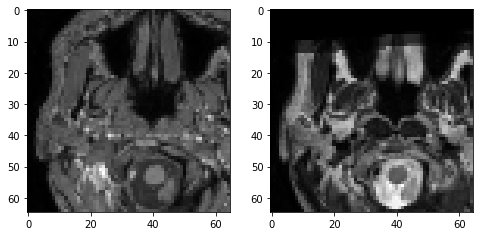

In [21]:
rand = RandomCrop3D(65)
df = NiftiDataset("../small_data/small/t1/", "../small_data/small/t2/", rand.generate_patch)

source, target = df[0]

fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(source[35, :, :], cmap="gray")
axis[1].imshow(target[35, :, :], cmap="gray")

In [49]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = torch.nn.Sequential(
                        torch.nn.Conv3d(120, 120, 3, 1, 1),
                        torch.nn.ReLU(),
                        torch.nn.Conv3d(120, 120, 3, 1, 1),
                        torch.nn.ReLU(),
                        torch.nn.Conv3d(120, 120, 3, 1, 1),

                                         )
    
    def forward(self, X):
        return self.layers(X)
    


In [50]:
net = ConvNet()

In [52]:
source_tensor = torch.from_numpy(source)
source_tensor.unsqueeze_(0)
source_tensor.unsqueeze_(-1)

output_tensor = net(source_tensor.float())

print(source_tensor.shape, output_tensor.shape)
assert source_tensor.shape == output_tensor.shape

torch.Size([1, 120, 65, 65, 1]) torch.Size([1, 120, 65, 65, 1])
